In [1]:
from scipy.sparse import csr_matrix
from implicit.als import AlternatingLeastSquares
import pandas as pd
import threadpoolctl
import numpy as np
from scipy.spatial.distance import cosine
from pathlib import Path
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error

/home/z/projects/st312haowan/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = Path('ml-latest-small')

tags = pd.read_csv(
    dataset_path/"tags.csv",
    sep=",",
)
ratings = pd.read_csv(
    dataset_path/"ratings.csv",
    sep=",",
)

movies = pd.read_csv(
    dataset_path/"movies.csv",
    sep=","
)
links = pd.read_csv(
    dataset_path/"links.csv",
    sep=","
)

In [145]:
# Normalise rating column in ratings df
ratings['rating'] = ratings['rating'] / 5.0

In [146]:
len(ratings.userId.unique())

610

Train Test Split

In [147]:
def get_last_n_ratings_by_user(
    df, n, min_ratings=1, user_colname="userId", timestamp_colname="timestamp"
):
    """
    Returns the last n ratings for each user in the given DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the ratings data.
        n (int): The number of last ratings to retrieve for each user.
        min_ratings (int, optional): The minimum number of ratings a user must have to be included. Defaults to 1.
        user_colname (str, optional): The name of the column containing the user IDs. Defaults to "userId".
        timestamp_colname (str, optional): The name of the column containing the timestamps. Defaults to "timestamp".

    Returns:
        pandas.DataFrame: A DataFrame containing the last n ratings for each user.

    """
# Filter users with enough ratings before sorting and grouping
    eligible_users = df.groupby(user_colname).filter(lambda x: len(x) >= min_ratings)[user_colname]
    return (
        df[df[user_colname].isin(eligible_users)]
        .sort_values(timestamp_colname)
        .groupby(user_colname)
        .tail(n)
        .sort_values(user_colname)
    )


In [148]:
def mark_last_n_ratings_as_validation_set(df, n, min_ratings=1, user_colname="userId", timestamp_colname="timestamp"):
    """
    Marks the last n ratings for each user as validation set and returns the updated DataFrame.

    Args:
        df (pandas.DataFrame): The input DataFrame containing the ratings data.
        n (int): The number of last ratings to mark as validation set for each user.
        min_ratings (int, optional): The minimum number of ratings a user must have to be included. Defaults to 1.
        user_colname (str, optional): The name of the column containing the user IDs. Defaults to "userId".
        timestamp_colname (str, optional): The name of the column containing the timestamps. Defaults to "timestamp".

    Returns:
        pandas.DataFrame: The updated DataFrame with the last n ratings for each user marked as validation set.

    """
    last_n_ratings = get_last_n_ratings_by_user(df, n, min_ratings, user_colname, timestamp_colname)
    df['is_valid'] = df.apply(lambda x: x.name in last_n_ratings.index, axis=1)
    return df

In [150]:
marked_ratings = mark_last_n_ratings_as_validation_set(ratings, n=2, min_ratings=20)
user_lookup = {v: i+1 for i, v in enumerate(marked_ratings['userId'].unique())}
movie_lookup = {v: i+1 for i, v in enumerate(marked_ratings['movieId'].unique())}
marked_ratings['user_index'] = marked_ratings['userId'].map(user_lookup)
marked_ratings['item_index'] = marked_ratings['movieId'].map(movie_lookup)
train = marked_ratings[~marked_ratings['is_valid']]
valid = marked_ratings[marked_ratings['is_valid']]
train_matrix = csr_matrix((train['rating'], (train['user_index'], train['item_index'])), shape = (611, 9725))
valid_matrix = csr_matrix((valid['rating'], (valid['user_index'], valid['item_index'])), shape = (611, 9725))

In [151]:
matrix_shape

(610, 9724)

In [152]:
train_matrix.shape

(611, 9725)

In [153]:
threadpoolctl.threadpool_limits(limits=1)
model = AlternatingLeastSquares(factors=100, regularization=1, iterations=20, calculate_training_loss=True, use_gpu=False)
model.fit(train_matrix) 

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:02<00:00,  9.62it/s, loss=0.00418]


In [154]:
preds_matrix = np.dot(model.user_factors, model.item_factors.T)


In [155]:
preds_validation = preds_matrix[valid_matrix.nonzero()]
preds_training = preds_matrix[train_matrix.nonzero()]
true_validation = valid_matrix.toarray()[valid_matrix.nonzero()]
true_training = train_matrix.toarray()[train_matrix.nonzero()]

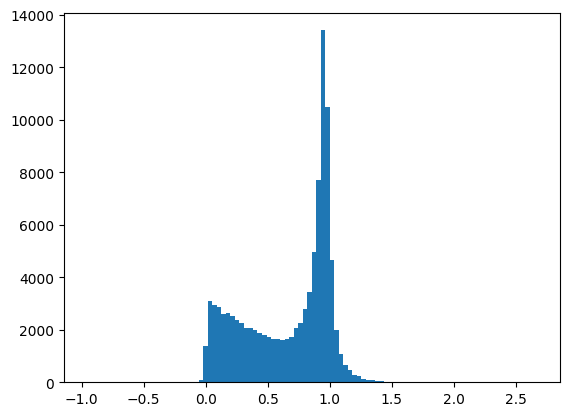

Mean: 0.6667284965515137
Standard deviation: 0.3454122245311737


In [156]:
# plot distribution for preds_training
import matplotlib.pyplot as plt
plt.hist(preds_training, bins=100)
plt.show()
# summary statistics on preds_training
print(f"Mean: {np.mean(preds_training)}")
print(f"Standard deviation: {np.std(preds_training)}")


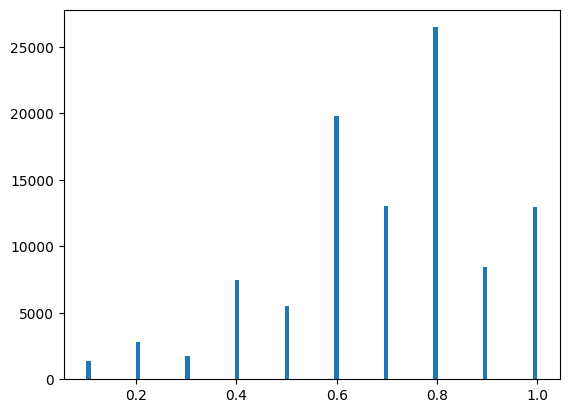

In [157]:
plt.hist(true_training, bins=100)
plt.show()

In [158]:
print(f"Mean: {np.mean(full_true)}")

Mean: 3.501556983616962


In [160]:
mean_squared_error(true_training, preds_training)

0.1538265090079266

In [163]:
mean_squared_error(true_training, np.full(len(true_training), 3.5/5))

0.0434204344683585

In [117]:
mean_squared_error(np.array([1,5,2]), np.array([5,3,1]))

7.0

In [133]:
full_true = np.concatenate([true_training, true_validation])

In [136]:
mean_squared_error(full_true, np.full(len(full_true), 4))
mean_absolute_error(full_true, np.full(len(full_true), 4))

0.845273513427744

Ignore below

In [83]:
true_matrix = true_matrix.toarray()
# Calculate novelty using cosine similarity
def calculate_novelty(item_factors):
    similarity_matrix = cosine_similarity(item_factors)
    mean_novelty = np.mean(np.tril(similarity_matrix, -1))
    return mean_novelty

train_novelty = calculate_novelty(item_factors)
valid_novelty = calculate_novelty(item_factors)

ValueError: Found input variables with inconsistent numbers of samples: [99616, 1]

In [ ]:

# Prepare indices for prediction
train_user_indices = np.array(list(user_lookup.values()))
train_item_indices = np.array(list(movie_lookup.values()))
valid_user_indices = np.array(list(user_lookup.values()))
valid_item_indices = np.array(list(movie_lookup.values()))


In [44]:
print(train_item_indices[0])
print(train_user_indices.shape)
print(model.item_factors.shape)
print(model.user_factors.shape)

1
(610,)
(9725, 50)
(611, 50)


In [36]:
valid_item_indices.shape

(9724,)

In [31]:
train_item_indices

array([   1,    2,    3, ..., 9722, 9723, 9724])

In [19]:
valid_user_indices

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [16]:
train_item_indices-1

array([   0,    1,    2, ..., 9721, 9722, 9723])

In [ ]:
train_user_indices

In [ ]:

train_data = marked_ratings[~marked_ratings['is_valid']]
validation_data = marked_ratings[marked_ratings['is_valid']]

In [ ]:
def create_sparse_matrix(df, users_col, items_col, ratings_col):
    users = df[users_col].astype('category')
    items = df[items_col].astype('category')
    ratings = df[ratings_col]
    return csr_matrix((ratings, (users.cat.codes, items.cat.codes))), dict(enumerate(users.cat.categories)), dict(enumerate(items.cat.categories))

train_matrix, train_user_dict, train_item_dict = create_sparse_matrix(train, 'userId', 'movieId', 'rating')
valid_matrix, valid_user_dict, valid_item_dict = create_sparse_matrix(valid, 'userId', 'movieId', 'rating')

In [116]:
user_item_matrix = csr_matrix((train_data['rating'], (train_data['userId'], train_data['movieId'])))

In [138]:
user_item_matrix.data

array([4., 4., 4., ..., 5., 5., 3.])

In [119]:
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(user_item_matrix)

100%|██████████| 10/10 [00:00<00:00, 11.34it/s]


In [126]:
predicted_ratings = []
actual_ratings = []

for user_id in user_ids:
    user_items = csr_matrix((validation_data[validation_data['userId'] == user_id]['rating'],
                             (np.zeros(validation_data[validation_data['userId'] == user_id].shape[0]),
                              validation_data[validation_data['userId'] == user_id]['movieId'])),
                            shape=(1, movie_ids.max()+1))
    
    recommended_items, scores = model.recommend(user_id, user_items, N=user_items.nnz)
    
    predicted_ratings.extend(scores)
    actual_ratings.extend(validation_data[validation_data['userId'] == user_id]['rating'])

In [133]:
mse = mean_squared_error(actual_ratings, predicted_ratings)
rmse = math.sqrt(mse)
mae = mean_absolute_error(actual_ratings, predicted_ratings)

In [136]:
mae

2.7314244633693185

In [121]:
user_ids = validation_data['userId'].unique()
movie_ids = validation_data['movieId'].unique()
validation_matrix = csr_matrix((validation_data['rating'], (validation_data['userId'], validation_data['movieId'])),
                               shape=(user_ids.max()+1, movie_ids.max()+1))
predicted_ratings = model(validation_matrix.nonzero()[0], validation_matrix.nonzero()[1])

TypeError: 'AlternatingLeastSquares' object is not callable

In [94]:
train_data = marked_ratings[~marked_ratings['is_valid']]
validation_data = marked_ratings[marked_ratings['is_valid']]

In [95]:
train_data

,userId,movieId,rating,timestamp,is_valid
0,1,1,4.0,964982703,False
1,1,3,4.0,964981247,False
2,1,6,4.0,964982224,False
3,1,47,5.0,964983815,False
4,1,50,5.0,964982931,False
...,...,...,...,...,...
100831,610,166534,4.0,1493848402,False
100832,610,168248,5.0,1493850091,False
100833,610,168250,5.0,1494273047,False
100834,610,168252,5.0,1493846352,False


In [96]:
validation_data

,userId,movieId,rating,timestamp,is_valid
119,1,2012,4.0,964984176,True
161,1,2492,4.0,965719662,True
247,2,80489,4.5,1445715340,True
257,2,114060,2.0,1445715276,True
281,3,2424,0.5,1306464293,True
...,...,...,...,...,...
99494,608,52245,3.0,1189563917,True
99528,609,833,3.0,847221080,True
99533,609,1161,4.0,847221080,True
99681,610,2459,3.5,1495959405,True


In [109]:
train_matrix = train_data.pivot(index='userId', columns='movieId', values='rating').fillna(0).to_numpy()
validation_matrix = validation_data.pivot(index='userId', columns='movieId', values='rating').fillna(0).to_numpy()

In [110]:
train_matrix

array([[4. , 0. , 4. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [2.5, 2. , 2. , ..., 0. , 0. , 0. ],
       [3. , 0. , 0. , ..., 0. , 0. , 0. ],
       [5. , 0. , 0. , ..., 0. , 0. , 0. ]])

In [111]:
validation_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [112]:
# train_data_matrix = train_matrix.replace(item_map).replace(user_map).fillna(0).to_numpy()
# validation_data_matrix = validation_matrix.replace(item_map).replace(user_map).fillna(0).to_numpy()

# Train ALS model
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(train_matrix)

AttributeError: 'numpy.ndarray' object has no attribute 'tocsr'

In [99]:
model = AlternatingLeastSquares(factors=50, regularization=0.01, iterations=10)
model.fit(train_data)

AttributeError: 'DataFrame' object has no attribute 'tocsr'

In [29]:


user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
user_item_sparse_matrix = csr_matrix(user_item_matrix.values)
model = AlternatingLeastSquares(factors=factors, regularization=regularization, iterations=iterations)
model.fit(user_item_sparse_matrix)
threadpoolctl.threadpool_limits(limits=1)
model = als_factorization(ratings)

ValueError: No CUDA extension has been built, can't train on GPU.

In [27]:
def get_als_recommendations(model, user_id, user_item_matrix, movies, num_recommendations=5):
    """
    Gets recommendations for a user using the trained ALS model.

    Args:
        model (AlternatingLeastSquares): Trained ALS model.
        user_id: ID of the user.
        user_item_matrix (pd.DataFrame): User-item matrix.
        movies (pd.DataFrame): DataFrame with movie information.
        num_recommendations (int): Number of recommendations to generate.

    Returns:
        list: List of recommended movie titles.
    """
    user_index = user_item_matrix.index.get_loc(user_id)
    user_ratings = user_item_sparse_matrix[user_index]
    recommended_movie_ids, _ = model.recommend(user_index, user_ratings, N=num_recommendations)
    recommended_movies = movies.loc[movies['movieId'].isin(recommended_movie_ids), 'title'].tolist()
    return recommended_movies

# Example usage
recommendations = get_als_recommendations(model, 1, user_item_matrix, movies)
print(recommendations)

NameError: name 'user_item_sparse_matrix' is not defined